# RNA-Seq Clustering

## Getting Data from GDC

I used two different queries to look up files for TP and NT on GDC (advanced search), added the files to cart, and downloaded separate manifest files for TP and NT. There are 500 files in the TP manifest and 44 files in the NT manifest.

The two queries differ in that the first specified `cases.samples.sample_type in ["primary tumor"]` and the second `cases.samples.sample_type in ["solid tissue normal"]`.

The main body of the query is the same as what I used in HW1:
```
cases.project.project_id in ["TCGA-HNSC"] and files.analysis.workflow_type in ["HTSeq - Counts"] and files.data_category in ["transcriptome profiling"] and files.experimental_strategy in ["RNA-Seq"]
```

I then extracted the UUIDs from the manifest file, constructed a JSON request body, and made a POST request to GDC using curl to download the files. The API endpoint for downloading files is `https://api.gdc.cancer.gov/data`. The download took about 5 minutes and has about 160 MB.

I put PT `htseq.counts` data into `data/primary_tumor/` and NT data into `data/solid_tissue_normal/`.

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
# normalize data
from sklearn.preprocessing import Normalizer
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

from IPython.display import display

In [21]:
def write_json_file(manifest):
    with open(manifest, 'rt') as f:
        lines = f.readlines()[1:] # skip header
    uuids = [line.split('\t')[0] for line in lines]
    jso = {'ids': uuids}
    jso_fname = manifest.split('.manifest.txt')[0] + '.json'
    with open(jso_fname, 'wt') as f:
        json.dump(jso, f)

In [22]:
write_json_file('data/primary_tumor.manifest.txt')
write_json_file('data/solid_tissue_normal.manifest.txt')

In [24]:
!curl --remote-name --remote-header-name \
--request POST --header 'Content-Type: application/json' \
--data @data/primary_tumor.json 'https://api.gdc.cancer.gov/data'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  119M    0  119M  100 20009   312k     51  0:06:32  0:06:29  0:00:03  303k:37  0:00:37 --:--:--  254k00 20009   188k    308  0:01:04  0:01:04 --:--:--  251k5M  100 20009   304k     59  0:05:39  0:05:35  0:00:04  137k
curl: Saved to filename 'gdc_download_20201014_205700.202302.tar.gz'


In [25]:
!curl --remote-name --remote-header-name \
--request POST --header 'Content-Type: application/json' \
--data @data/solid_tissue_normal.json 'https://api.gdc.cancer.gov/data'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10.4M    0 10.4M  100  1769   234k     38  0:00:46  0:00:45  0:00:01  240k0  1769  99892    442  0:00:04  0:00:04 --:--:-- 99920
curl: Saved to filename 'gdc_download_20201014_210309.859494.tar.gz'


# Reading and Cleaning Data

We remove non-gene columns: `__no_feature, __ambiguous, __too_low_aQual, __not_aligned, __alignment_not_unique`

Read data from the two directors as a $N \times P$ matrix

$N$: num rows/samples/observations/patients  
$P$: num columns/features/genes

In [11]:
def read_data_matrix(directories):
    """
    returns P * N dataframe
    """
    dataframes = []
    sample_idx = 0
    for idx, directory in enumerate(directories):
        files = os.listdir(directory)
        for f in files:
            sample_idx += 1
            # drop non-gene columns and 0
            df = pd.read_csv(os.path.join(directory, f), 
                             sep='\t', header=None, 
                             index_col=0, # use gene name as index
                             names=['gene', 
                                    'sample{}'.format(sample_idx)])
            df.drop(['__no_feature', '__ambiguous', 
                     '__too_low_aQual', '__not_aligned', 
                     '__alignment_not_unique'], inplace=True)
#             df.replace(0, np.nan, inplace=True)
#             df.dropna(inplace=True)
            
            dataframes.append(df)
    return dataframes
    ret_df = pd.concat(dataframes, axis=1, join='outer')
#     ret_df.replace(0, np.nan, inplace=True)
#     ret_df.dropna(how='all', inplace=True)
#     ret_df.replace(np.nan, 0, inplace=True)
    return ret_df

In [12]:
d = read_data_matrix(['data/solid_tissue_normal'])

In [17]:
df = pd.concat(d, axis=1, join='inner')
df.replace(0, np.nan, inplace=True)
df.dropna(how='all', inplace=True)
df.replace(np.nan, 0, inplace=True)

In [18]:
df.head()

,sample1,sample2,sample3,sample4,sample5,sample6,sample7,sample8,sample9,sample10,...,sample35,sample36,sample37,sample38,sample39,sample40,sample41,sample42,sample43,sample44
gene,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003.13,2652.0,4202.0,8492.0,11257.0,2518.0,9616.0,4901.0,6030.0,5539.0,6791.0,...,4370.0,7224.0,11809.0,1645.0,2537.0,1883.0,11523.0,2359.0,2768.0,9952.0
ENSG00000000005.5,62.0,43.0,3.0,0.0,34.0,0.0,31.0,13.0,30.0,8.0,...,3.0,21.0,4.0,42.0,41.0,8.0,0.0,18.0,14.0,9.0
ENSG00000000419.11,1462.0,1576.0,1578.0,2677.0,1512.0,1887.0,1659.0,1428.0,1967.0,2025.0,...,2064.0,1941.0,1623.0,1862.0,1171.0,1301.0,2626.0,1716.0,1888.0,2403.0
ENSG00000000457.12,817.0,604.0,818.0,1322.0,742.0,1017.0,1048.0,1167.0,710.0,1127.0,...,648.0,1191.0,981.0,405.0,557.0,385.0,895.0,464.0,618.0,832.0
ENSG00000000460.15,190.0,165.0,281.0,658.0,301.0,169.0,362.0,228.0,239.0,383.0,...,367.0,154.0,299.0,111.0,127.0,201.0,369.0,166.0,251.0,437.0


In [6]:
raw_data = read_data_matrix(['data/primary_tumor', 
                             'data/solid_tissue_normal'])

In [7]:
raw_data.head()

,sample1,sample2,sample3,sample4,sample5,sample6,sample7,sample8,sample9,sample10,...,sample535,sample536,sample537,sample538,sample539,sample540,sample541,sample542,sample543,sample544
gene,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003.13,2254.0,3113.0,6344.0,1416.0,2287.0,4128.0,1626.0,1141.0,3897.0,2646.0,...,4370.0,7224.0,11809.0,1645.0,2537.0,1883.0,11523.0,2359.0,2768.0,9952.0
ENSG00000000005.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,18.0,...,3.0,21.0,4.0,42.0,41.0,8.0,0.0,18.0,14.0,9.0
ENSG00000000419.11,1268.0,2076.0,2938.0,2329.0,2782.0,2827.0,2172.0,815.0,1858.0,2293.0,...,2064.0,1941.0,1623.0,1862.0,1171.0,1301.0,2626.0,1716.0,1888.0,2403.0
ENSG00000000457.12,689.0,944.0,494.0,801.0,629.0,546.0,949.0,991.0,1165.0,1259.0,...,648.0,1191.0,981.0,405.0,557.0,385.0,895.0,464.0,618.0,832.0
ENSG00000000460.15,979.0,1223.0,631.0,777.0,464.0,469.0,902.0,486.0,949.0,1067.0,...,367.0,154.0,299.0,111.0,127.0,201.0,369.0,166.0,251.0,437.0


In [19]:
# data cleaning
data = raw_data.T # N samples * P genes
data.columns.name = 'sample'
data.reset_index(inplace=True)
data.drop(columns=['index'], inplace=True)
# add disease status label column, PT vs. TN
data['disease'] = \
['PT' for _ in range(len(os.listdir('data/primary_tumor')))] + \
['TN' for _ in range(len(os.listdir('data/solid_tissue_normal')))]

In [23]:
data.shape

(544, 57940)

In [24]:
data.to_csv('data/clean/data_big.csv')

In [213]:
data = pd.read_csv('data/clean/data.csv', index_col=0)

In [ ]:
data.head()

We have 500 PT + 44 TN = 544 samples and 14349 - 1 = 14348 genes as features (the last column is the patient's disease status).

# Before Normalizing, Show PCA for Raw Data

In [25]:
# produce X and y
matrix = data.loc[:, data.columns != 'disease'].to_numpy()
# 0 for PT and 1 for TN
int_labels = data['disease'].astype('category').cat.codes

In [26]:
def visualize_2d(X_2d, y, labels, title):
    target_ids = range(len(labels))
    fig = plt.figure(figsize=(14, 6))
    for i, c, label in zip(target_ids, 'rgbcmykw', labels):
        plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1],
                   c=c, label=label)
    plt.legend()
    plt.title(title)
    plt.show()

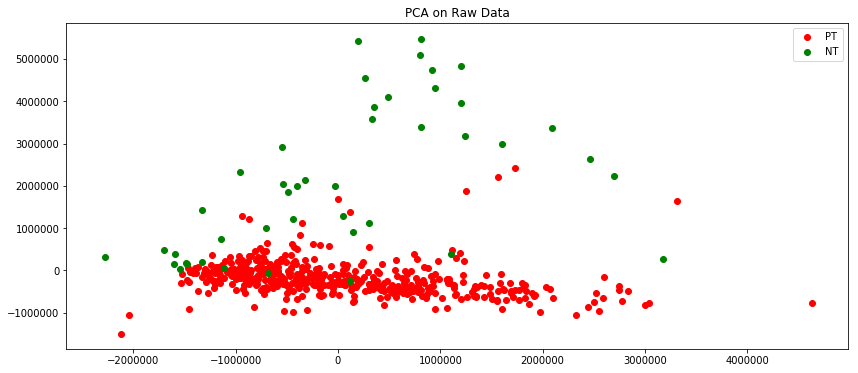

In [27]:
matrix_pca = PCA(n_components=2).fit_transform(matrix)
visualize_2d(matrix_pca, int_labels, ['PT', 'NT'], 'PCA on Raw Data')

## Let's see how K-Means perform on non-normalized data

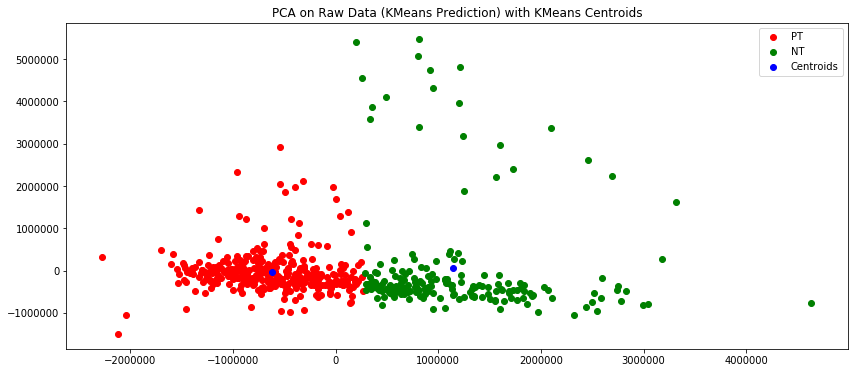

In [28]:
matrix_kmeans = KMeans(n_clusters=2, random_state=0).fit(matrix)
matrix_kmeans_pca = PCA(n_components=2).fit_transform(
    np.concatenate([matrix, matrix_kmeans.cluster_centers_]))

visualize_2d(matrix_kmeans_pca, 
             np.concatenate([matrix_kmeans.labels_, [2, 2]]), 
             ['PT', 'NT', 'Centroids'], 
             'PCA on Raw Data (KMeans Prediction) with KMeans Centroids')

We observe that the clusters K-Means produced aren't very good. Let's see if we get better performance with normalization.

# Normalizing Counts

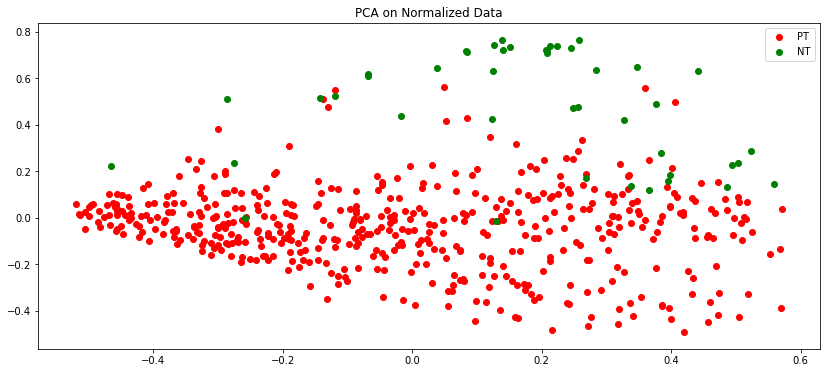

In [29]:
normalized = Normalizer().fit_transform(matrix)
normalized_pca = PCA(n_components=2).fit_transform(normalized)
visualize_2d(normalized_pca, int_labels, ['PT', 'NT'], 'PCA on Normalized Data')

We observe that the normalized data seems more separable than the raw data.

In [273]:
temp = PCA(n_components=50).fit_transform(normalized)
normalized_tsne = TSNE(n_components=2, verbose=1).fit_transform(temp)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 544 samples in 0.007s...
[t-SNE] Computed neighbors for 544 samples in 0.072s...
[t-SNE] Computed conditional probabilities for sample 544 / 544
[t-SNE] Mean sigma: 0.186253
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.056709
[t-SNE] KL divergence after 1000 iterations: 0.877019


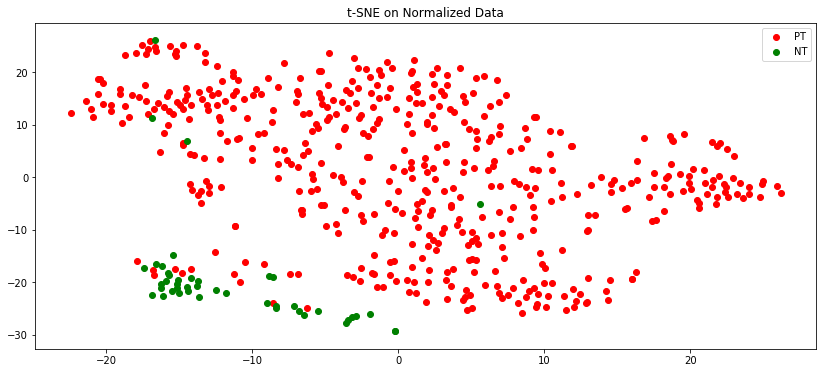

In [274]:
visualize_2d(normalized_tsne, int_labels, ['PT', 'NT'], 't-SNE on Normalized Data')

# K-Means Clustering on Normalized Data

In [30]:
normalized_kmeans = KMeans(n_clusters=2, random_state=0).fit(normalized)

In [31]:
with_centroids = PCA(n_components=2).fit_transform(
    np.concatenate([normalized, normalized_kmeans.cluster_centers_]))

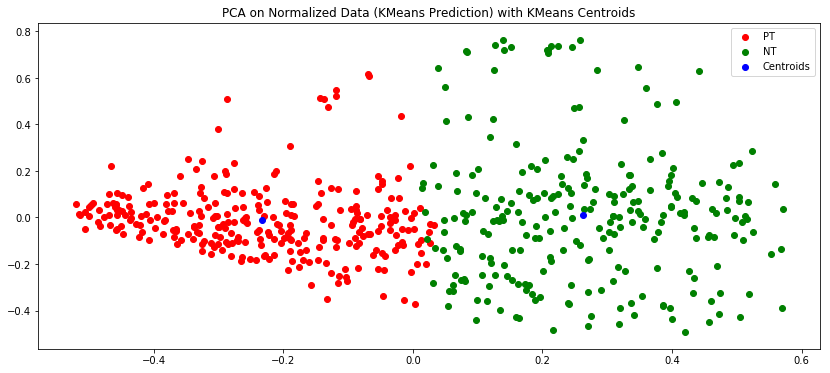

In [32]:
visualize_2d(with_centroids, 
             np.concatenate([normalized_kmeans.labels_, [2, 2]]), 
             ['PT', 'NT', 'Centroids'], 
             'PCA on Normalized Data (KMeans Prediction) with KMeans Centroids')

As we can observe from the difference between the true labels and K-Means prediction, performing K-Means clustering on normalized data still doesn't give us sufficiently good results.

# Try First Reducing Dimensionality with PCA
One possible cause for the failure of K-Means might be that Euclidean distance tend to work poorly in high-dimensional space. We only have 544 samples but 14k+ features. Let's try reducing the number of features to 100.

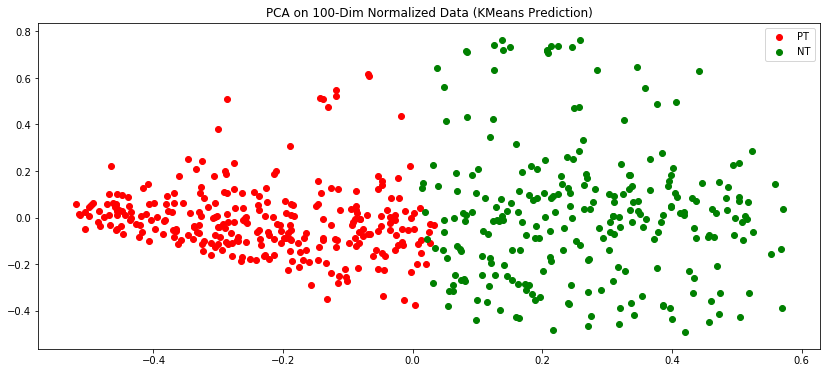

In [33]:
normalized_100 = PCA(n_components=100).fit_transform(normalized)
normalized_100_kmeans = KMeans(n_clusters=2, random_state=0).fit(normalized_100)
visualize_2d(normalized_100, normalized_100_kmeans.labels_, ['PT', 'NT'], 
             'PCA on 100-Dim Normalized Data (KMeans Prediction)')

Unfortunately, K-Means still perform poorly.

# We next explore hierarchical clustering algorithms
Reference: https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

In [278]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

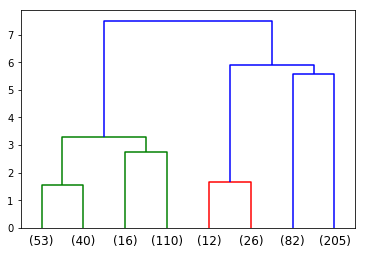

In [286]:
normalized_dendro = AgglomerativeClustering(distance_threshold=0, 
                                            n_clusters=None).fit(normalized)
plot_dendrogram(normalized_dendro, truncate_mode='level', p=2)

# Writeup

## 1. How you prepared the data for clustering. 
I cleaned the data, removing non-gene features and genes with zero counts. I stored the data into a $N \times P$ matrix, where $N$ is the number of patients/samples and $P$ is the number of genes/features. There are 500 PT and 44 TN samples and 14k+ genes.

## 2.What algorithms that you used for clustering.
I used K-Means with $k=2$ as well as hierarchical clustering.

## 3.How you visualized the clustering.
I reduced the dimensionality using PCA and t-SNE.

## 4.How you convinced yourself that the clustering was valid.
The clusters identified by K-Means aren't very good, probably because K-Means don't work well with high-dimensional data where the number of features far exceed the number of samples.

## 5.Any biological interpretations that you can associate with the clusters (extra credit).